In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.python.keras.models import Sequential, Model, load_model
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [3]:
# Import test dataset
imagesPath = './X_test204.npy'
labelsPath = './y_test204.npy'

X_test = np.load(imagesPath)
y_test = np.load(labelsPath, allow_pickle=True)

print('Images shape: ', X_test.shape, ' Labels shape: ', y_test.shape)

Images shape:  (6000, 256, 256, 1)  Labels shape:  (6000, 5)


In [ ]:
# Let's make a directory called 'Figures' where all the images will be saved
!mkdir /path to working directory/Figures
# Replace 'path to working directory' with your actual working directory e.g '/home/daniel_work/Documents/Machine_Learning/Notebooks/Layered/DAS/'

In [4]:
# Normalize test data
scalery = MinMaxScaler()
scalery.fit(y_test)
y_test = scalery.transform(y_test)

In [5]:
# Load and evaluate saved model
model   = load_model("./BestDAS_Resnet204.h5")
scores = model.evaluate(X_test, y_test, verbose=2)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [8]:
# Perform predictions
pred  = model.predict(X_test)
pred1 = scalery.inverse_transform(pred)
y_test1= scalery.inverse_transform(y_test)

In [10]:
# Remove noise: We expect events from a depth of 1000m downwards so we use a seive of 500m
mask_ytests, mask_preds = y_test1[:,1]<500, pred1[:,1]<500
y_tests, preds = y_test1[~mask_ytests], pred1[~mask_preds]
print(y_tests.shape, preds.shape)

(5000, 5) (5000, 5)


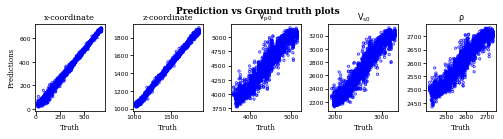

In [13]:
# Plot correlation plots for events locations (x,z) and velocity model parameters
fig = plt.figure(figsize=(8.27,1.6))
gs  = gridspec.GridSpec(1,5, width_ratios=[1,1,1,1,1], hspace=0.3, wspace=0.4)
fig.suptitle('Prediction vs Ground truth plots', fontname='serif', fontsize=9, fontweight='bold', y=1.03)

# Plot x Coordinates
ax0  = plt.subplot(gs[0])
ax0.scatter(y_tests[:,0], preds[:,0],facecolors='none', edgecolors='b', s=5, alpha=0.7)
ax0.set_title('x-coordinate', fontname='serif', fontsize=8, pad=4)
ax0.set_xlabel('Truth', fontname='serif',fontsize=7)
ax0.set_ylabel('Predictions', fontname='serif', fontsize=7)
ax0.tick_params(axis='both', labelsize=6, pad=.5)

# Plot z Coordinates
ax1  = plt.subplot(gs[1])
ax1.scatter(y_tests[:,1], preds[:,1],facecolors='none', edgecolors='b', s=5, alpha=0.7)
ax1.set_title('z-coordinate', fontname='serif', fontsize=8, pad=4)
ax1.set_xlabel('Truth', fontname='serif', fontsize=7)
ax1.tick_params(axis='both', labelsize=6, pad=.5)

# Plot vp
ax2  = plt.subplot(gs[2])
ax2.scatter(y_tests[:,2], preds[:,2],facecolors='none', edgecolors='b', s=5, alpha=0.7)
ax2.set_title(r'$\mathsf{V_{p0}}$', fontname='serif', fontsize=8, pad=4)
ax2.set_xlabel('Truth', fontname='serif', fontsize=7)
ax2.tick_params(axis='both', labelsize=6, pad=.5)

# Plot vs
ax3  = plt.subplot(gs[3])
ax3.scatter(y_tests[:,3], preds[:,3],facecolors='none', edgecolors='b', s=5, alpha=0.7)
ax3.set_title(r'$\mathsf{V_{s0}}$', fontname='serif', fontsize=8, pad=4)
ax3.set_xlabel('Truth', fontname='serif', fontsize=7)
ax3.tick_params(axis='both', labelsize=6, pad=.5)

# Plot rho 
ax4  = plt.subplot(gs[4])
ax4.scatter(y_tests[:,4], preds[:,4],facecolors='none', edgecolors='b', s=5, alpha=0.7)
ax4.set_title(r'$\mathsf{\rho}$', fontname='serif', fontsize=8, pad=4)
ax4.set_xlabel('Truth', fontname='serif', fontsize=7)
ax4.tick_params(axis='both', labelsize=6, pad=.5)

plt.savefig('./Figures/Correlation_plots.png', bbox_inches='tight', dpi=800)
plt.show()

In [14]:
## Error analysis
## Calculate mean absolute errors
errors= (preds - y_tests)
msex, msez = np.mean(np.absolute(errors[:,0]))*100/(np.mean(y_tests[:,0])), np.mean(np.absolute(errors[:,1]))*100/(np.mean(y_tests[:,1]))
msep ,mses = np.mean(np.absolute(errors[:,2]))*100/(np.mean(y_tests[:,2])), np.mean(np.absolute(errors[:,3]))*100/(np.mean(y_tests[:,3]))
mser = np.mean(np.absolute(errors[:,4]))*100/(np.mean(y_tests[:,4]))

print(msex, msez, msep, mses, mser)

2.043307760331933 0.7247875294222371 2.757852177729484 4.190692072434219 0.9711676145716244


In [15]:
## Calculate standard deviations
stdx, stdz = np.std(errors[:,0])*100/np.std(y_tests[:,0]), np.std(errors[:,1])*100/np.std(y_tests[:,1])
stdp, stds = np.std(errors[:,2])*100/np.std(y_tests[:,2]), np.std(errors[:,3])*100/np.std(y_tests[:,3])
stdr = np.std(errors[:,4])*100/np.std(y_tests[:,4])
print(stdx, stdz, stdp, stds, stdr)

5.488909241841622 4.796151658503588 26.319699315416187 24.57506451626312 26.962962207432568


In [16]:
## calculate interquartile range
iqrx, iqrz = stats.iqr(errors[:,0], interpolation='midpoint'), stats.iqr(errors[:,1], interpolation='midpoint')
iqrp, iqrs = stats.iqr(errors[:,2], interpolation='midpoint'), stats.iqr(errors[:,3], interpolation='midpoint')
iqrr = stats.iqr(errors[:,3], interpolation='midpoint')
print(iqrx, iqrz, iqrp, iqrs, iqrr)

7.921850585937506 12.00079345703125 76.9891357421875 57.8331298828125 57.8331298828125


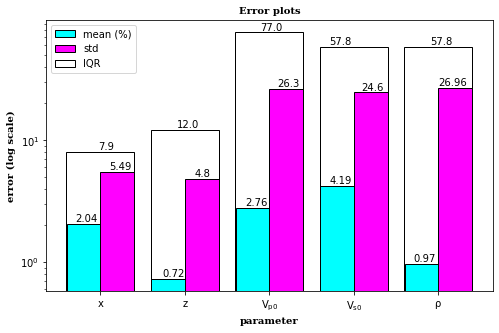

In [24]:
## Plot histogram of errors
fig, ax = plt.subplots(figsize=(8,5))

mean = [msex, msez, msep, mses, mser]
std  = [stdx, stdz, stdp, stds, stdr]
ermax= [iqrx, iqrz, iqrp, iqrs, iqrr]

width = 0.40

# Set position on X-axis
p1 = np.arange(len(mean))
p2 = [i + width for i in p1]
p3 = p1+0.2

# Make the plot
plt.bar(p1, mean, color='cyan', width=width,edgecolor='black', label='mean (%)')
plt.bar(p2, std, color='fuchsia', width=width,edgecolor='black', label='std')
plt.bar(p3, ermax, color='none', width=width*2.01,edgecolor='black', label='IQR')

# Add xticks on the middle of the group bars
plt.xlabel('parameter', fontname='serif', fontweight='bold')
plt.ylabel('error (log scale)',fontname='serif', fontweight='bold')
plt.xticks([j + width-0.2 for j in range(len(mean))], [r'$\mathsf{x}$', r'$\mathsf{z}$',r'$\mathsf{V_{p0}}$', r'$\mathsf{V_{s0}}$',r'$\mathsf{\rho}$'])
plt.yscale('log')
plt.title('Error plots', fontsize=10,fontname='serif', fontweight='bold')

plt.text(-0.1, round(msex,2)+0.1,round(msex,2))
plt.text(0.30, round(stdx,2)+0.23,round(stdx,2))
plt.text(0.17, round(iqrx,1)+.5,round(iqrx,1))

plt.text(0.93, round(msez,2)+0.04,round(msez,2))
plt.text(1.31, round(stdz,2)+0.2,round(stdz,2))
plt.text(1.10, round(iqrz,1)+.7,round(iqrz,1))

plt.text(1.92, round(msep,2)+0.15,round(msep,2))
plt.text(2.29, round(stdp,2)+1.0,round(stdp,1))
plt.text(2.09, round(iqrp,1)+3,round(iqrp,1))

plt.text(2.91, round(mses,2)+0.19,round(mses,2))
plt.text(3.29, round(stds,1)+1.0,round(stds,1))
plt.text(2.91, round(iqrs,1)+3,round(iqrs,1))

plt.text(3.90, round(mser,2)+0.05,round(mser,2))
plt.text(4.20, round(stdr,2)+1, round(stdr,2))
plt.text(4.10, round(iqrr,1)+3,round(iqrr,1))

plt.legend(loc='upper left')
plt.savefig('./Figures/Error_histograms.png',bbox_inches = "tight", dpi=800)
plt.show()

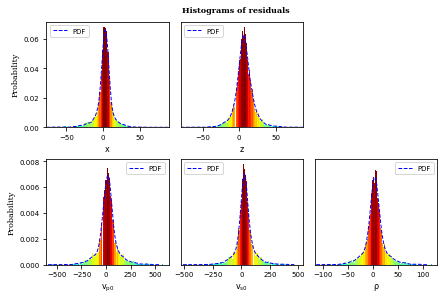

In [54]:
## Plot histogram of residuals
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import scipy.stats as st
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

x, z, vp, vs, rh = errors[:,0], errors[:,1], errors[:,2], errors[:,3], errors[:,4]

# Bins for x
xq25, xq75 = np.percentile(x,[.25,.75])
xbin_width = 2*(xq75 - xq25)*len(x)**(-1/3)
xn_bins = round((x.max() - x.min())/xbin_width).astype(int)

# Bins for z
zq25, zq75 = np.percentile(z,[.25,.75])
zbin_width = 2*(zq75 - zq25)*len(z)**(-1/3)
zn_bins = round((z.max() - z.min())/zbin_width).astype(int)

# Bins for vp
vpq25, vpq75 = np.percentile(vp,[.25,.75])
vpbin_width = 2*(vpq75 - vpq25)*len(vp)**(-1/3)
vpn_bins = round((vp.max() - vp.min())/vpbin_width).astype(int)

# Bins for vs
vsq25, vsq75 = np.percentile(vs,[.25,.75])
vsbin_width = 2*(vsq75 - vsq25)*len(vs)**(-1/3)
vsn_bins = round((vs.max() - vs.min())/vsbin_width).astype(int)

# Bins for rho
rhq25, rhq75 = np.percentile(rh,[.25,.75])
rhbin_width = 2*(rhq75 - rhq25)*len(rh)**(-1/3)
rhn_bins = round((rh.max() - rh.min())/rhbin_width).astype(int)
  
    

fig = plt.figure(figsize=(7,7))
gs  = gridspec.GridSpec(3,3, height_ratios=[1,1,1], width_ratios=[1,1,1], wspace=0.1, hspace=0.3)
fig.suptitle('Histograms of residuals', fontname='serif', fontsize=8, fontweight='bold', y=0.91)

# Histogram for x
ax0  = plt.subplot(gs[0])
xN, xbins, xpatches = ax0.hist(x, density=True, bins = xn_bins, rwidth=.99)
## Set color
xfracs = ((xN**(1 / 5)) / xN.max())
xnorm = colors.Normalize(xfracs.min(), xfracs.max())

for thisfrac, thispatch in zip(xfracs, xpatches):
    xcolor = plt.cm.jet(xnorm(thisfrac))
    thispatch.set_facecolor(xcolor)

xmn, xmx = plt.xlim()
plt.xlim(xmn, xmx)    

xkde_xs = np.linspace(xmn, xmx, 500)
xkde = st.gaussian_kde(x)
ax0.plot(xkde_xs, xkde.pdf(xkde_xs),'--', color='blue',lw=1, label="PDF")
ax0.legend(loc="upper left", fontsize=7)
ax0.set_ylabel('Probability', fontsize=8, fontname='serif')
ax0.tick_params(axis='both', labelsize=7)

# Histogram for z
ax1  = plt.subplot(gs[1])
zN, zbins, zpatches = ax1.hist(z, density=True, bins = zn_bins, rwidth=.99)
## Set color
zfracs = ((zN**(1 / 5)) / zN.max())
znorm = colors.Normalize(zfracs.min(), zfracs.max())

for thisfrac, thispatch in zip(zfracs, zpatches):
    zcolor = plt.cm.jet(znorm(thisfrac))
    thispatch.set_facecolor(zcolor)

zmn, zmx = plt.xlim()
plt.xlim(zmn, zmx)    

zkde_xs = np.linspace(zmn, zmx, 500)
zkde = st.gaussian_kde(z)
ax1.plot(zkde_xs, zkde.pdf(zkde_xs),'--', color='blue',lw=1, label="PDF")
ax1.legend(loc="upper left", fontsize=7)
ax1.set_xlabel(r'$\mathsf{z}$', fontsize=8)
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.tick_params(axis='both', labelsize=7)


# Histogram for vp
ax2  = plt.subplot(gs[3])
vpN, vpbins, vppatches = ax2.hist((vp-np.std(vp)), density=True, bins = vpn_bins, rwidth=.99)
## Set color
vpfracs = ((vpN**(1 / 5)) / vpN.max())
vpnorm = colors.Normalize(vpfracs.min(), vpfracs.max())

for thisfrac, thispatch in zip(vpfracs, vppatches):
    vpcolor = plt.cm.jet(vpnorm(thisfrac))
    thispatch.set_facecolor(vpcolor)

vpmn, vpmx = plt.xlim()
plt.xlim(vpmn, vpmx)    

vpkde_xs = np.linspace(vpmn, vpmx, 500)
vpkde = st.gaussian_kde(vp)
ax2.plot(vpkde_xs-np.std(vp), vpkde.pdf(vpkde_xs),'--', color='blue',lw=1, label="PDF")
ax2.legend(loc="upper right", fontsize=7)
ax2.set_ylabel('Probability', fontsize=8, fontname='serif')
ax2.set_xlabel(r'$\mathsf{v_{p0}}$', fontsize=8)
ax2.tick_params(axis='both', labelsize=7)

# Histogram for vs
ax3  = plt.subplot(gs[4])
vsN, vsbins, vspatches = ax3.hist((vs-np.std(vs)), density=True, bins = vsn_bins, rwidth=.99)
## Set color
vsfracs = ((vsN**(1 / 5)) / vsN.max())
vsnorm = colors.Normalize(vsfracs.min(), vsfracs.max())

for thisfrac, thispatch in zip(vsfracs, vspatches):
    vscolor = plt.cm.jet(vsnorm(thisfrac))
    thispatch.set_facecolor(vscolor)

vsmn, vsmx = plt.xlim()
plt.xlim(vsmn, vsmx)    

vskde_xs = np.linspace(vsmn, vsmx, 500)
vskde = st.gaussian_kde(vs)
ax3.plot(vskde_xs-np.std(vs), vskde.pdf(vskde_xs),'--', color='blue',lw=1, label="PDF")
ax3.legend(loc="upper left", fontsize=7)
ax3.set_xlabel(r'$\mathsf{v_{s0}}$', fontsize=8)
ax3.set_yticks([])
ax3.set_yticklabels
ax3.tick_params(axis='both', labelsize=7)

# Histogram for rho
ax4  = plt.subplot(gs[5])
rhN, rhbins, rhpatches = ax4.hist((rh-np.std(rh)), density=True, bins = rhn_bins, rwidth=.99)
## Set color
rhfracs = ((rhN**(1 / 5)) / rhN.max())
rhnorm = colors.Normalize(rhfracs.min(), rhfracs.max())

for thisfrac, thispatch in zip(rhfracs, rhpatches):
    rhcolor = plt.cm.jet(rhnorm(thisfrac))
    thispatch.set_facecolor(rhcolor)

rhmn, rhmx = plt.xlim()
plt.xlim(rhmn, rhmx)    

rhkde_xs = np.linspace(rhmn, rhmx, 500)
rhkde = st.gaussian_kde(rh)
ax4.plot(rhkde_xs-np.std(rh), rhkde.pdf(rhkde_xs),'--', color='blue',lw=1, label="PDF")
ax4.legend(loc="upper right", fontsize=7)
ax4.set_xlabel(r'$\mathsf{\rho}$', fontsize=8)
ax4.set_yticks([])
ax4.set_yticklabels([])
ax4.tick_params(axis='both', labelsize=7)

plt.savefig('./Figures/Histogram of residuals.png', dpi=800, bbox_inches='tight')
plt.show()

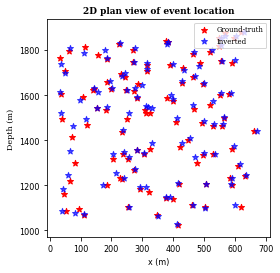

In [38]:
plt.figure(figsize=(4,4))
plt.scatter(y_tests[:100,0], y_tests[:100,1], marker='*',facecolors='red', edgecolors='red', s=40, alpha=1,label='Ground-truth')
plt.scatter(preds[:100,0], preds[:100,1], marker='*',facecolors='blue', edgecolors='blue', s=40, alpha=0.7, label='Inverted')
plt.title('2D plan view of event location', fontname='serif', fontsize=9, fontweight='bold')
plt.ylabel('Depth (m)', fontname='serif', fontsize=8)
plt.xlabel('x (m)', fontsize=8)
plt.tick_params(labelsize=8)
plt.legend(loc='upper right', prop={'family':'serif','size':7})
plt.savefig('./Figures/Plan_view.png', bbox_inches='tight', dpi=800)
plt.show()

In [58]:
## Prepare velocity model data
velTrue = y_tests.reshape(50,100,5)
velPred = preds.reshape(50,100,5)

vmodelsort, vmodel_predsort = [],[]
for i in range(50):
    vmodel = velTrue[i]
    vmodelsorts = vmodel[vmodel[:,1].argsort()]
    vmodelsort.append(vmodelsorts)
    
    vmodelPred = velPred[i]
    vmodel_predsorts=vmodelPred[vmodelPred[:,1].argsort()]
    vmodel_predsort.append(vmodel_predsorts)
vmodelsort, vmodel_predsort = np.array(vmodelsort), np.array(vmodel_predsort)

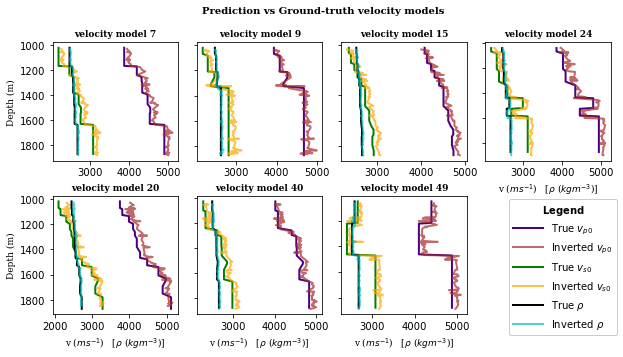

In [59]:
## Plot velocity models

fig = plt.figure(figsize=(10,5))
gs  = gridspec.GridSpec(2,4, width_ratios=[1,1,1,1], height_ratios=[1,1], hspace=0.3, wspace=0.15)
fig.suptitle('Prediction vs Ground-truth velocity models', fontname='serif', fontsize=10, fontweight='bold', y=.98)

i = 6
ax1  = plt.subplot(gs[0])
ax1.plot(vmodelsort[i,:,2], vmodelsort[i,:,1], 'indigo',linewidth=2, alpha=1, label = 'True $v_p$')
ax1.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,1], color='brown',linewidth=2, alpha=0.7, label = 'Inverted $v_p$')
ax1.plot(vmodelsort[i,:,3], vmodelsort[i,:,1], 'g', linewidth=2, alpha=1, label = 'True $v_s$')
ax1.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,1], color='orange',linewidth=2, alpha=0.7, label = 'Inverted $v_s$')
ax1.plot(vmodelsort[i,:,4], vmodelsort[i,:,1], 'k', linewidth=2, alpha=1, label = r'True $\rho$')
ax1.plot(vmodel_predsort[i,:,4], vmodel_predsort[i,:,1],'c',linewidth=2, alpha=0.7, label = r'Inverted $\rho$')
ax1.set_ylabel('Depth (m)', fontsize=9, fontname='serif')
ax1.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
plt.gca().invert_yaxis()


i = 8
ax2  = plt.subplot(gs[1])
ax2.plot(vmodelsort[i,:,2], vmodelsort[i,:,1], 'indigo', linewidth=2, alpha=1, label = 'True $v_p$')
ax2.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,1], color='brown', linewidth=2, alpha=0.7, label = 'Inverted $v_p$')
ax2.plot(vmodelsort[i,:,3], vmodelsort[i,:,1], 'g', linewidth=2, alpha=1, label = 'True $v_s$')
ax2.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,1], color='orange',linewidth=2, alpha=0.7, label = 'Inverted $v_s$')
ax2.plot(vmodelsort[i,:,4], vmodelsort[i,:,1], 'k', linewidth=2, alpha=1, label = r'True $\rho$')
ax2.plot(vmodel_predsort[i,:,4], vmodel_predsort[i,:,1],'c',linewidth=2, alpha=0.7, label = r'Inverted $\rho$')
ax2.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax2.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 14
ax3  = plt.subplot(gs[2])
ax3.plot(vmodelsort[i,:,2], vmodelsort[i,:,1], 'indigo', linewidth=2, alpha=1, label = 'True $v_p$')
ax3.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,1], color='brown', linewidth=2, alpha=0.7, label = 'Inverted $v_p$')
ax3.plot(vmodelsort[i,:,3], vmodelsort[i,:,1], 'g', linewidth=2, alpha=1, label = 'True $v_s$')
ax3.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,1], color='orange',linewidth=2, alpha=0.7, label = 'Inverted $v_s$')
ax3.plot(vmodelsort[i,:,4], vmodelsort[i,:,1], 'k', linewidth=2, alpha=1, label = r'True $\rho$')
ax3.plot(vmodel_predsort[i,:,4], vmodel_predsort[i,:,1],'c',linewidth=2, alpha=0.7, label = r'Inverted $\rho$')
ax3.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax3.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 23
ax4  = plt.subplot(gs[3])
ax4.plot(vmodelsort[i,:,2], vmodelsort[i,:,1], 'indigo', linewidth=2, alpha=1, label = 'True $v_p$')
ax4.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,1], color='brown', linewidth=2, alpha=0.7, label = 'Inverted $v_{p}$')
ax4.plot(vmodelsort[i,:,3], vmodelsort[i,:,1], 'g', linewidth=2, alpha=1, label = 'True $v_s$')
ax4.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,1], color='orange',linewidth=2, alpha=0.7, label = 'Inverted $v_s$')
ax4.plot(vmodelsort[i,:,4], vmodelsort[i,:,1], 'k', linewidth=2, alpha=1, label = r'True $\rho$')
ax4.plot(vmodel_predsort[i,:,4], vmodel_predsort[i,:,1],'c',linewidth=2, alpha=0.7, label = r'Inverted $\rho$')
ax4.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax4.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax4.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 19
ax5  = plt.subplot(gs[4])
ax5.plot(vmodelsort[i,:,2], vmodelsort[i,:,1], 'indigo', linewidth=2, alpha=1, label = 'True $v_p$')
ax5.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,1], color='brown', linewidth=2, alpha=0.7, label = 'Inverted $v_p$')
ax5.plot(vmodelsort[i,:,3], vmodelsort[i,:,1], 'g', linewidth=2, alpha=1, label = 'True $v_s$')
ax5.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,1], color='orange',linewidth=2, alpha=0.7, label = 'Inverted $v_s$')
ax5.plot(vmodelsort[i,:,4], vmodelsort[i,:,1], 'k', linewidth=2, alpha=1,label = r'True $\rho$')
ax5.plot(vmodel_predsort[i,:,4], vmodel_predsort[i,:,1],'c',linewidth=2, alpha=0.7, label = r'Inverted $\rho$')
ax5.set_ylabel('Depth (m)', fontsize=9, fontname='serif')
ax5.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax5.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
plt.gca().invert_yaxis()

i = 39
ax6  = plt.subplot(gs[5])
ax6.plot(vmodelsort[i,:,2], vmodelsort[i,:,1], 'indigo', linewidth=2, alpha=1, label = 'True $v_p$')
ax6.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,1], color='brown', linewidth=2, alpha=0.7, label = 'Inverted $v_p$')
ax6.plot(vmodelsort[i,:,3], vmodelsort[i,:,1], 'g', linewidth=2, alpha=1, label = 'True $v_s$')
ax6.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,1], color='orange',linewidth=2, alpha=0.7, label = 'Inverted $v_s$')
ax6.plot(vmodelsort[i,:,4], vmodelsort[i,:,1], 'k', linewidth=2, alpha=1, label = r'True $\rho$')
ax6.plot(vmodel_predsort[i,:,4], vmodel_predsort[i,:,1],'c',linewidth=2, alpha=0.7, label = r'Inverted $\rho$')
ax6.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax6.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax6.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 48
ax7  = plt.subplot(gs[6])
ax7.plot(vmodelsort[i,:,2], vmodelsort[i,:,1], 'indigo', linewidth=2, alpha=1, label = 'True $v_{p0}$')
ax7.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,1], color='brown', linewidth=2, alpha=0.7, label = 'Inverted $v_{p0}$')
ax7.plot(vmodelsort[i,:,3], vmodelsort[i,:,1], 'g', linewidth=2, alpha=1, label = 'True $v_{s0}$')
ax7.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,1], color='orange',linewidth=2, alpha=0.7, label = 'Inverted $v_{s0}$')
ax7.plot(vmodelsort[i,:,4], vmodelsort[i,:,1], 'k', linewidth=2, alpha=1, label = r'True $\rho$')
ax7.plot(vmodel_predsort[i,:,4], vmodel_predsort[i,:,1],'c',linewidth=2, alpha=0.7, label = r'Inverted $\rho$')
ax7.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax7.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax7.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()


plt.gca().legend(loc='center left', title='$\mathbf{Legend}$',bbox_to_anchor=(1.3, 0.4), framealpha=1, handlelength=3)


ax4.yaxis.set_label_position('right')
plt.savefig('./Figures/vmodelplots.png', dpi=800, bbox_inches='tight')
plt.show()

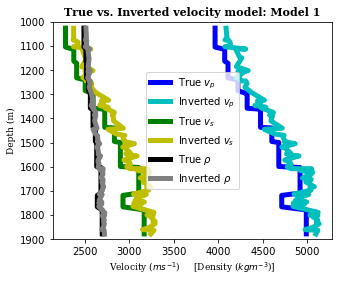

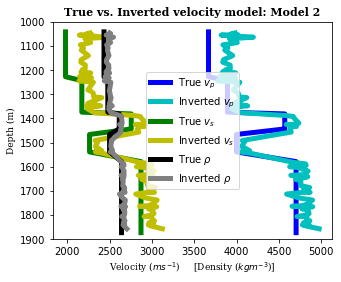

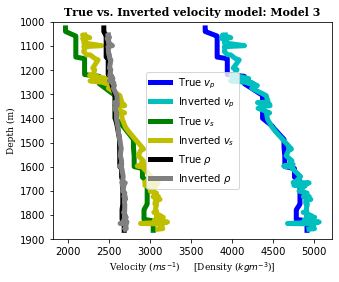

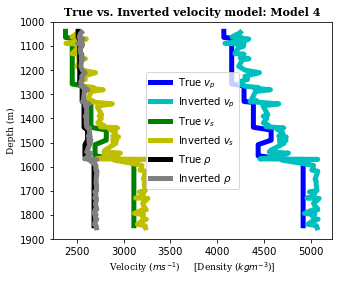

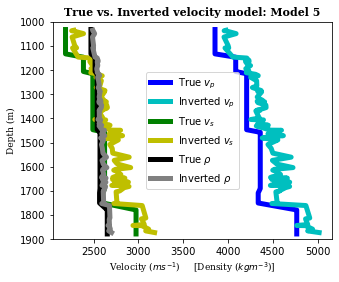

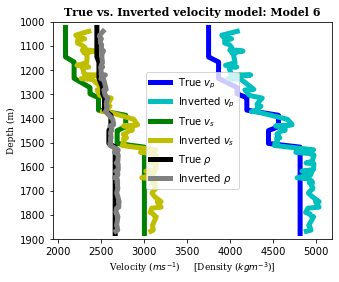

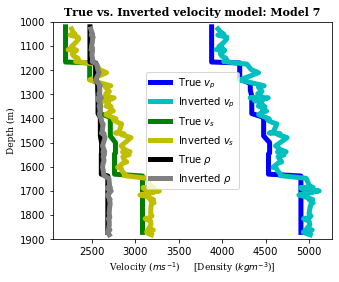

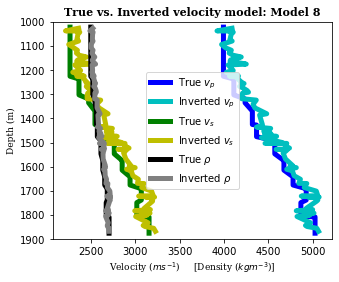

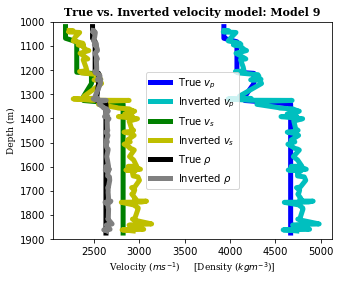

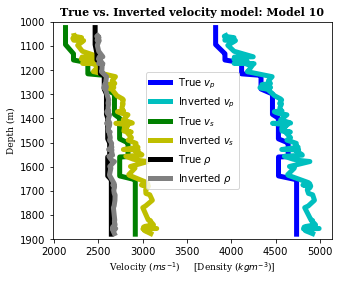

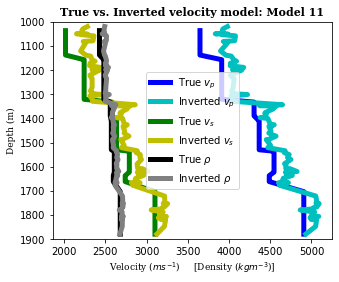

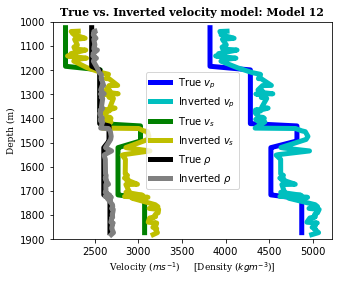

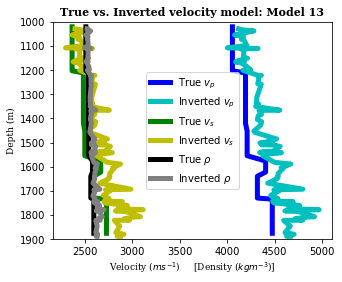

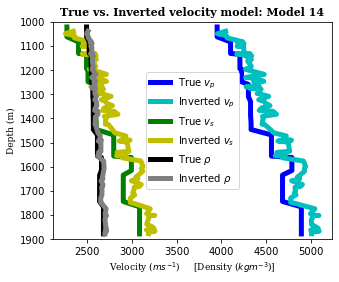

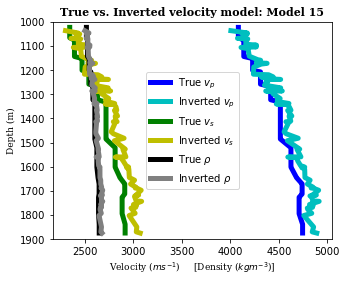

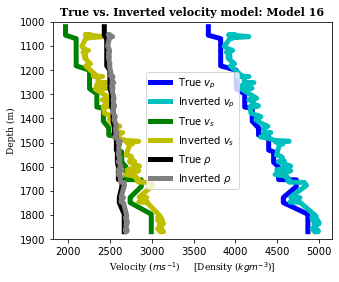

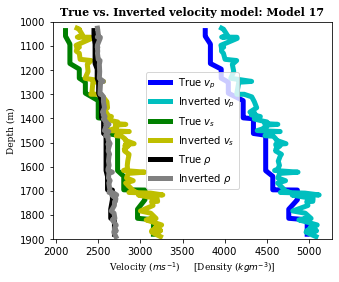

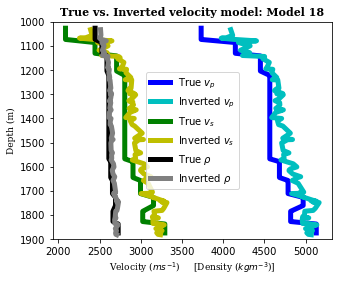

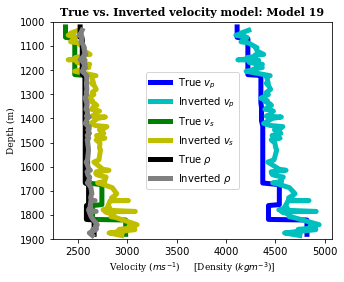

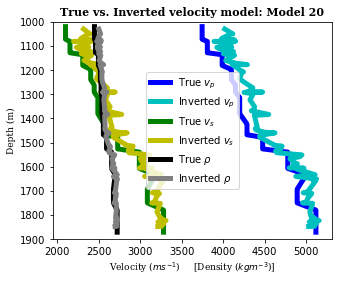

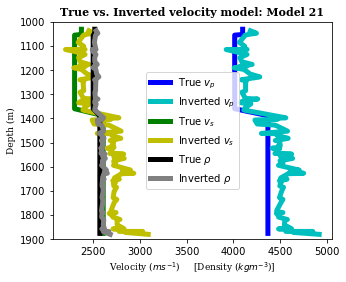

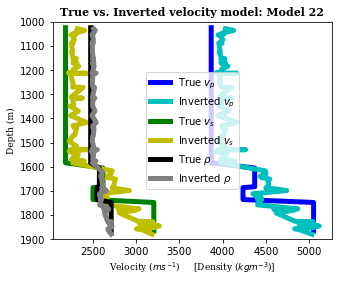

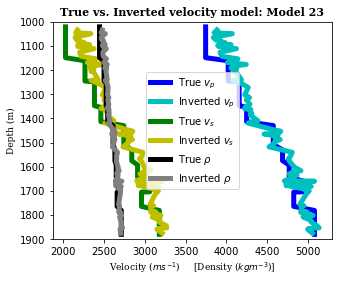

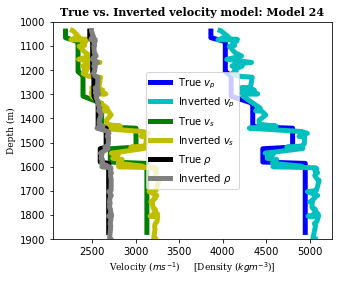

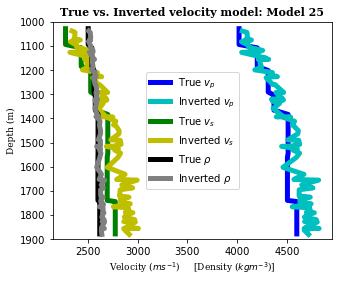

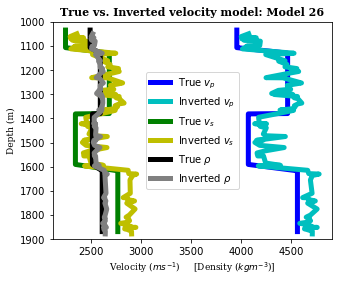

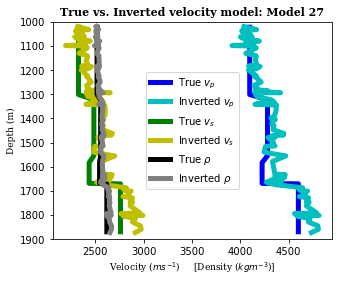

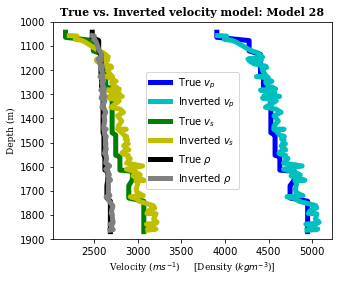

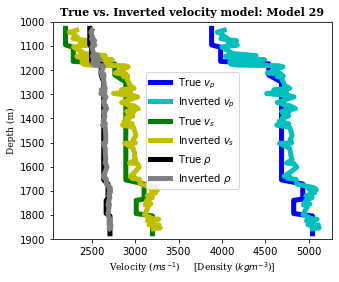

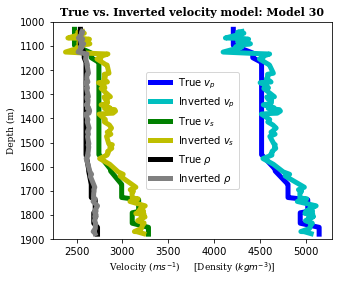

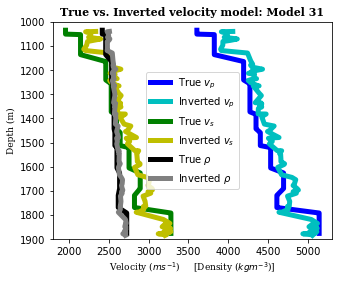

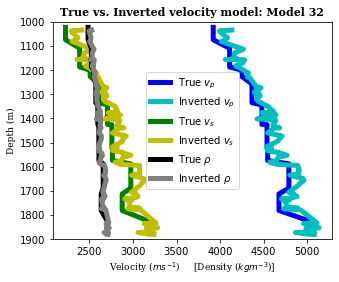

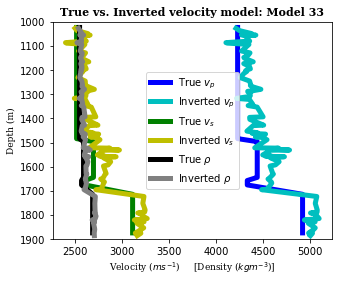

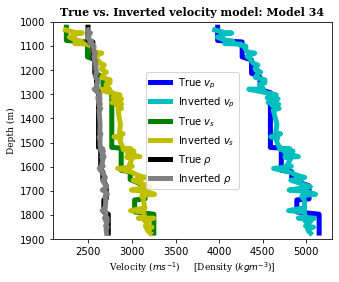

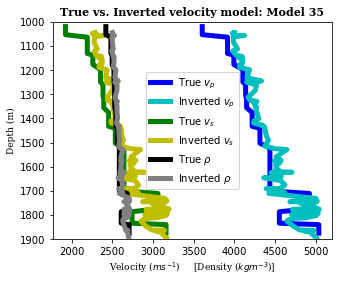

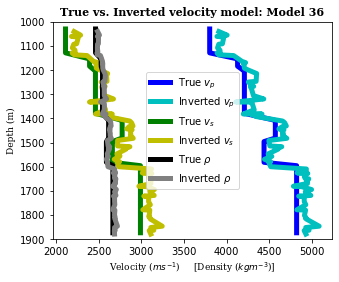

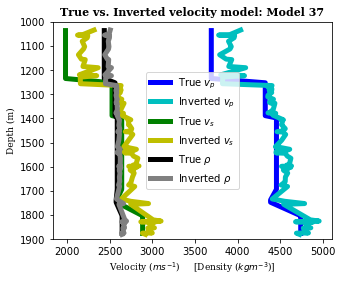

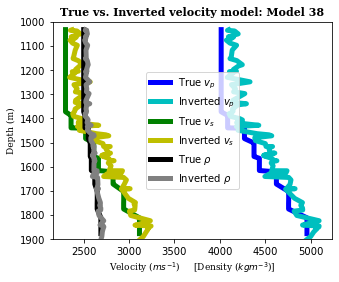

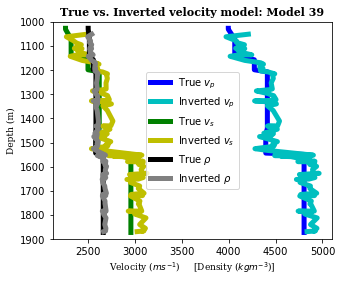

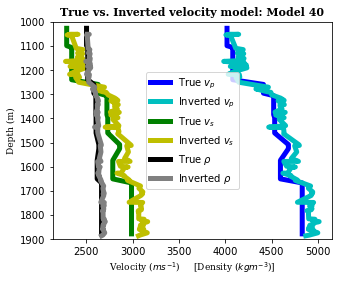

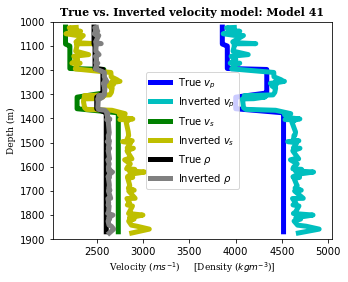

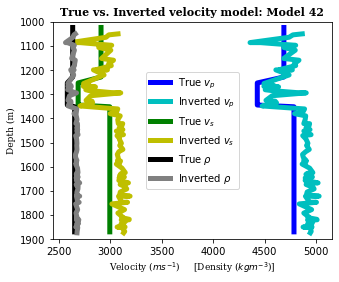

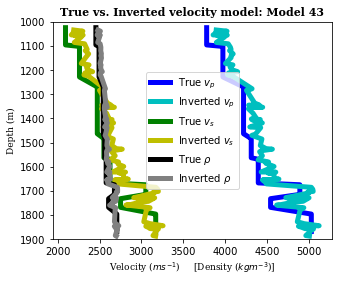

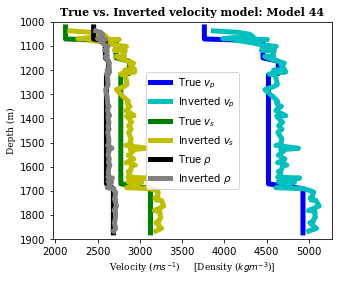

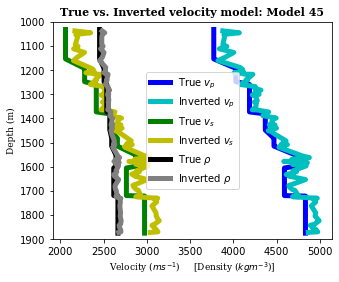

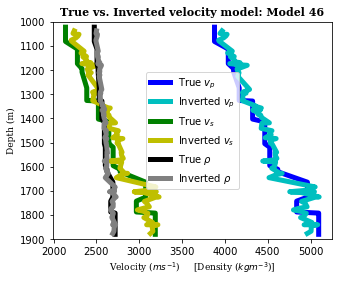

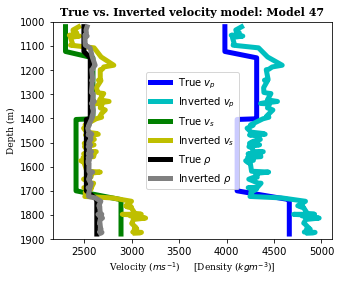

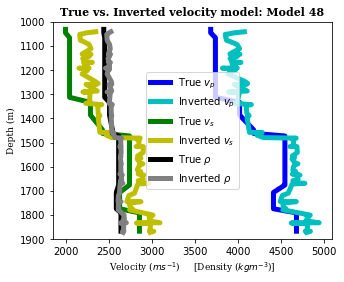

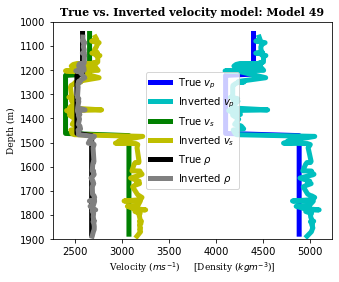

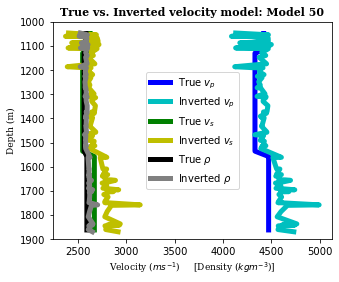

In [46]:
#Plot all the velocity models
for i in range(50):
    vmodel = velTrue[i]
    vmodelsort = vmodel[vmodel[:,1].argsort()]
    
    vmodelPred = velPred[i]
    vmodelPredsort=vmodelPred[vmodelPred[:,1].argsort()]
    
    plt.figure(figsize=(5,4))
    plt.plot(vmodelsort[:,2], vmodelsort[:,1], 'b', linewidth=5, label = 'True $v_p$')
    plt.plot(vmodelPredsort[:,2], vmodelPredsort[:,1], 'c', linewidth=5, label = 'Inverted $v_p$')
    plt.plot(vmodelsort[:,3], vmodelsort[:,1], 'g', linewidth=5, label = 'True $v_s$')
    plt.plot(vmodelPredsort[:,3], vmodelPredsort[:,1], 'y', linewidth=5, label = 'Inverted $v_s$')
    plt.plot(vmodelsort[:,4], vmodelsort[:,1], 'k', linewidth=5, label = r'True $\rho$')
    plt.plot(vmodelPredsort[:,4], vmodelPredsort[:,1], 'grey', linewidth=5, label = r'Inverted $\rho$')
    plt.ylabel('Depth (m)', fontsize=9, fontname='serif')
    plt.ylim(1000, 1900)
    plt.xlabel('Velocity ($ms^{-1}$)\t [Density ($kgm^{-3}$)]',  fontsize=9, fontname='serif')
    plt.title('True vs. Inverted velocity model: Model %d'%(i+1), fontsize=11, fontname='serif', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.legend(loc=10)
    plt.savefig('./Figures/vmodel_%d.png'%(i+1), dpi=800)
    plt.show()